# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import shutil

from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.applications import ResNet50

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import cv2
import time


# Creating the folder and uploaded kaggle.json

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

100% 226M/226M [00:13<00:00, 22.1MB/s]
100% 226M/226M [00:13<00:00, 18.0MB/s]


# Unzipping the Dataset

In [4]:
from zipfile import ZipFile

dataset = "/content/butterfly-image-classification.zip"

with ZipFile(dataset,"r") as zip:
  zip.extractall()
  print("Dataset is been extracted ")

Dataset is been extracted 


# Adding the Train-Test Path

In [5]:
train_dir = "/content/train"
test_dir = "/content/test"

In [6]:
train_df = pd.read_csv("/content/Training_set.csv")
test_df = pd.read_csv("/content/Testing_set.csv")

# Distribution of labels across Train Dataset

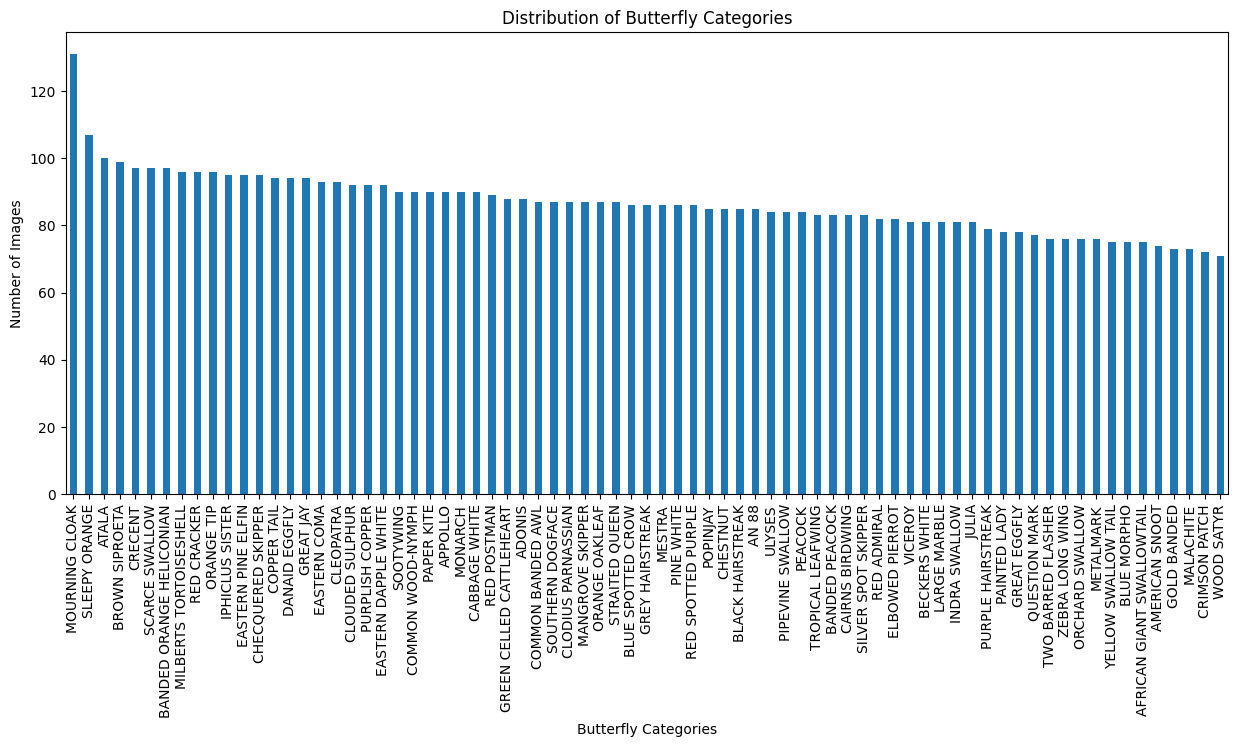

In [7]:
plt.figure(figsize = (15,6))
train_df["label"].value_counts().plot(kind = "bar")
plt.title("Distribution of Butterfly Categories")
plt.xlabel("Butterfly Categories")
plt.ylabel("Number of Images")
plt.show()

# Setting parameters for model

In [8]:
image_size = (150,150)
batch_size = 32
epochs = 2
learning_rate = 0.0009


In [9]:
class_names = list(set(train_df["label"]))
print(len(class_names))

75


In [10]:
list(set(train_df["label"]))

['BECKERS WHITE',
 'GREY HAIRSTREAK',
 'AN 88',
 'LARGE MARBLE',
 'ZEBRA LONG WING',
 'AMERICAN SNOOT',
 'PAINTED LADY',
 'PINE WHITE',
 'MONARCH',
 'PAPER KITE',
 'ULYSES',
 'MANGROVE SKIPPER',
 'RED CRACKER',
 'CHECQUERED SKIPPER',
 'STRAITED QUEEN',
 'SOOTYWING',
 'PURPLISH COPPER',
 'PEACOCK',
 'APPOLLO',
 'GOLD BANDED',
 'SILVER SPOT SKIPPER',
 'VICEROY',
 'SCARCE SWALLOW',
 'TROPICAL LEAFWING',
 'YELLOW SWALLOW TAIL',
 'COMMON BANDED AWL',
 'MESTRA',
 'POPINJAY',
 'ATALA',
 'ADONIS',
 'RED ADMIRAL',
 'MOURNING CLOAK',
 'MILBERTS TORTOISESHELL',
 'ORCHARD SWALLOW',
 'METALMARK',
 'RED SPOTTED PURPLE',
 'PIPEVINE SWALLOW',
 'BLUE SPOTTED CROW',
 'JULIA',
 'CABBAGE WHITE',
 'EASTERN PINE ELFIN',
 'COMMON WOOD-NYMPH',
 'COPPER TAIL',
 'PURPLE HAIRSTREAK',
 'EASTERN COMA',
 'BLUE MORPHO',
 'DANAID EGGFLY',
 'CRIMSON PATCH',
 'INDRA SWALLOW',
 'BLACK HAIRSTREAK',
 'RED POSTMAN',
 'WOOD SATYR',
 'GREEN CELLED CATTLEHEART',
 'SOUTHERN DOGFACE',
 'GREAT JAY',
 'TWO BARRED FLASHER',
 'CAIR

# Initializing Feature and Labels for Dataset

In [11]:
features = []
labels = []

for image in tqdm(os.listdir(train_dir),desc = "Preprocessing of Images"):
  label_name = train_df.loc[train_df["filename"]==image,"label"].values[0]
  label = class_names.index(label_name)
  image_read = cv2.imread(os.path.join(train_dir,image))
  image_resized = cv2.resize(image_read,image_size)
  image_normalized = image_resized/255.0
  features.append(image_normalized)
  labels.append(label)



Preprocessing of Images: 100%|██████████| 6499/6499 [00:16<00:00, 383.92it/s]


In [12]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [13]:
print(len(features))
print(len(labels))

6499
6499


In [14]:
features = np.asarray(features)
labels = np.asarray(labels)

# Splitting the Dataset in Train-Test-Split

In [15]:
x_train,x_test,y_train,y_test = train_test_split(features,
                                                 labels,
                                                 train_size = 0.7,
                                                 random_state = 42)

x_valid,x_test,y_valid,y_test = train_test_split(
                                                x_test,
                                                y_test,
                                                test_size = 0.5,
                                                random_state = 42)


In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [17]:
resnet50_v2 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

resnet101_v2 = "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5"


# Create the Instance of Model

In [18]:
def create_model(model_url,num_classes = 75):

  feature_extractor_layer = hub.KerasLayer(
                                    model_url,
                                    trainable= False,
                                    name= "Feature_Extraction_Layer",
                                    input_shape = image_size +(3,)
  )

  model = tf.keras.Sequential([
      feature_extractor_layer,
      Dense(256,activation = "relu"),
      layers.Dense(num_classes,activation = "softmax",name = "output_layer")
  ])

  return model

In [19]:
model = create_model(resnet50_v2,num_classes = 75)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (  (None, 1001)              25615849  
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 256)               256512    
                                                                 
 output_layer (Dense)        (None, 75)                19275     
                                                                 
Total params: 25891636 (98.77 MB)
Trainable params: 275787 (1.05 MB)
Non-trainable params: 25615849 (97.72 MB)
_________________________________________________________________


# Compilaton of Model

In [ ]:
model.compile(
    optimizer = Adam(learning_rate),
    loss = "sparse_categorical_crossentrspy",
    metrics = ["accuray"]
)


from datetime import datetime
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
                              filepath = "RESNET_50_V2_MODEL.h5",
                              verbose = True,
                              save_best_only = True
)

early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 10)

start_time = time.time()

history = model.fit(
                x_train,
                y_train,
                epochs = epochs,
                validation_data = (x_valid,y_valid),
                callbacks = [model_checkpoint,early_stopping],
                batch_size = batch_size

)

end_time = time.time()



# Plotting Training and Loss Curve

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,"b",label = "TRAINING LOSS")
plt.plot(epochs,loss,"r",label = "VALIDATION LOSS")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("sample_image.png",dpi = 100)
plt.show()